In [1]:
%pip install jupyter ipykernel matplotlib numpy tensorflow scikit-learn seaborn Pillow


Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
from tensorflow.keras.regularizers import l1_l2
from sklearn.utils import class_weight
from PIL import Image

2024-11-24 22:36:23.192126: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-24 22:36:23.193519: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-24 22:36:23.197241: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-24 22:36:23.208726: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732487783.229329  394520 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732487783.23

In [3]:
training_dir = '/home/ark/FMD/FMD/Dataset/Train'
testing_dir = '/home/ark/FMD/FMD/Dataset/Test'
validation_dir = '/home/ark/FMD/FMD/Dataset/Validation'

In [4]:
IMG_SIZE = (256, 256)

training_data = tf.keras.preprocessing.image_dataset_from_directory(training_dir,
                                                                 label_mode='categorical',
                                                                 batch_size=32,
                                                                 image_size=IMG_SIZE)

validation_data = tf.keras.preprocessing.image_dataset_from_directory(validation_dir,
                                                                      label_mode='categorical',
                                                                      batch_size=32,
                                                                      image_size=IMG_SIZE)

testing_data = tf.keras.preprocessing.image_dataset_from_directory(testing_dir,
                                                                 label_mode='categorical',
                                                                 batch_size=32,
                                                                 image_size=IMG_SIZE,
                                                                 shuffle=False)

Found 140002 files belonging to 2 classes.


W0000 00:00:1732487790.711679  394520 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Found 39428 files belonging to 2 classes.
Found 10905 files belonging to 2 classes.


In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(2)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping


In [6]:
from PIL import Image, ImageChops, ImageEnhance
import os
import itertools

False 1
True 0
False 1
False 1
True 0


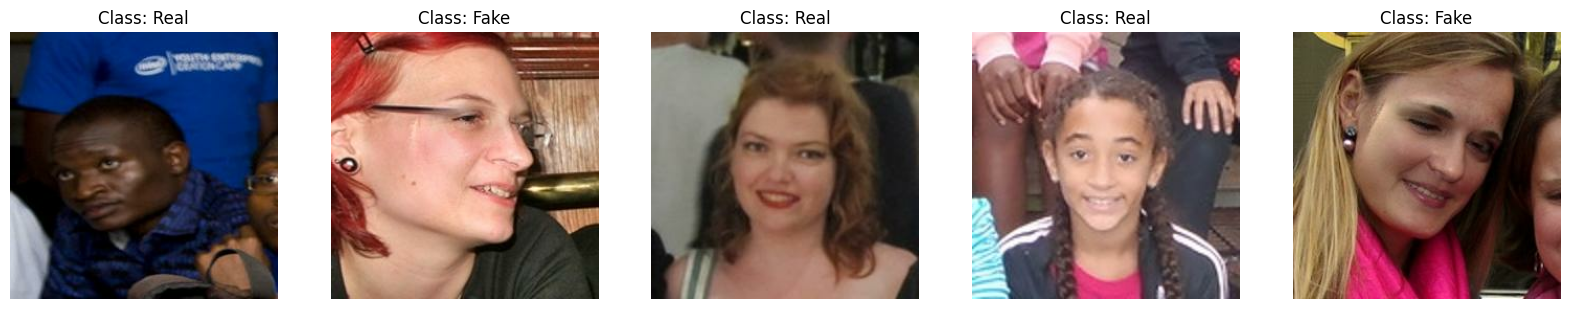

2024-11-24 22:36:33.559658: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [7]:
for images, labels in training_data.take(1):
  # Visualize the first 'n' images
  n = 5
  plt.figure(figsize=(20, 20))
  for i in range(n):
      ax = plt.subplot(1, n, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      # Assuming you have two classes and the label [1, 0] corresponds to 'Fake' and [0, 1] to 'Real'
      label = 'Fake' if np.argmax(labels[i].numpy()) == 0 else 'Real'
      print(np.argmax(labels[i].numpy()) == 0, np.argmax(labels[i].numpy()))
      plt.title("Class: " + label)
      plt.axis("off")
  plt.show()

In [8]:
def normalize_image(image, label):
    # Normalize the image pixels to the range [0, 1]
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Apply the normalization function to the datasets
training_data = training_data.map(normalize_image)
validation_data = validation_data.map(normalize_image)
testing_data = testing_data.map(normalize_image)

In [9]:
model1 = Sequential([
    # First convolutional layer
    Conv2D(filters=32, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=(256, 256, 3), kernel_constraint=MaxNorm(3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Second convolutional layer
    Conv2D(filters=64, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same", kernel_constraint=MaxNorm(3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Third convolutional layer
    Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same", kernel_constraint=MaxNorm(3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Fourth convolutional layer - reducing kernel size
    Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same", kernel_constraint=MaxNorm(3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Flatten the output for dense layers
    Flatten(),

    # Dense layer
    Dense(1024, activation='relu', kernel_constraint=MaxNorm(3)),
    Dropout(0.5),

    # Output layer
    Dense(2, activation='softmax')  # Softmax for binary classification
])

/home/ark/FMD/FMD/env/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │        11,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 31, 31, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 31, 31, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 15, 15, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 15, 15, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 7, 7, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,360,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         2,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,796,226 (10.67 MB)

 Trainable params: 2,795,266 (10.66 MB)

 Non-trainable params: 960 (3.75 KB)

In [11]:
# Initial parameters
epochs = 50
initial_lrate = 0.01

# Create the SGD optimizer without the decay parameter
sgd = SGD(learning_rate=initial_lrate, momentum=0.9, nesterov=False)

# Function to calculate the learning rate decay
def decay(epoch, lrate):
    return initial_lrate / (1 + decay_rate * epoch)

# Calculate the decay rate
decay_rate = initial_lrate / epochs
# Create a LearningRateScheduler callback to adjust the learning rate during training
lrate_scheduler = LearningRateScheduler(lambda epoch: decay(epoch, initial_lrate))

# Compile the model
model1.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [12]:
history = model1.fit(training_data, validation_data=validation_data, epochs=epochs, callbacks=[lrate_scheduler])

Epoch 1/50
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 559s 127ms/step - accuracy: 0.6521 - loss: 0.8048 - val_accuracy: 0.7511 - val_loss: 0.5311 - learning_rate: 0.0100
Epoch 2/50
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 556s 127ms/step - accuracy: 0.7899 - loss: 0.4482 - val_accuracy: 0.8613 - val_loss: 0.3176 - learning_rate: 0.0100
Epoch 3/50
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 556s 127ms/step - accuracy: 0.8600 - loss: 0.3242 - val_accuracy: 0.8683 - val_loss: 0.3029 - learning_rate: 0.0100
Epoch 4/50
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 557s 127ms/step - accuracy: 0.8949 - loss: 0.2539 - val_accuracy: 0.9059 - val_loss: 0.2298 - learning_rate: 0.0100
Epoch 5/50
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 556s 127ms/step - accuracy: 0.9108 - loss: 0.2155 - val_accuracy: 0.9196 - val_loss: 0.2077 - learning_rate: 0.0100
Epoch 6/50
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 557s 127ms/step - accuracy: 0.9209 - loss: 0.1931 - val_accuracy: 0.9163 - val_loss: 0.2111 - learning_rate: 0.0100
Epoch 7/50
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 557s 127ms

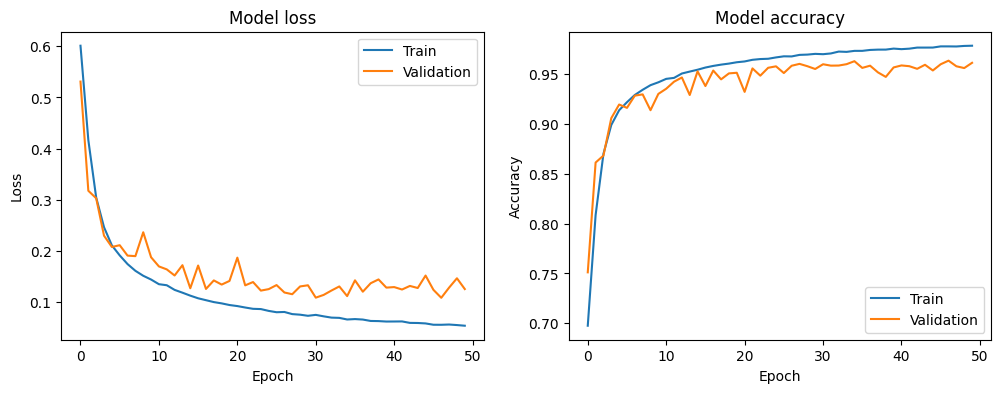

In [13]:
# Plot training & validation loss values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.show()


In [14]:
model1.save('FID_Media_Detection_aft.keras')

In [19]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

# Define parameters
IMAGE_SIZE = (224, 224)  # Adjust to match your model's input
BATCH_SIZE = 32          # Number of images to process at once

# Directory path
TEST_DIR = '/home/ark/FMD/FMD/Dataset/Test'  # Path to your test directory

# Load the pre-trained model
model = load_model('FID_Media_Detection_aft.keras')

# Data generator for test images
test_datagen = ImageDataGenerator(rescale=1.0/255)  # Normalize pixel values

# Flow test images from the directory with categorical labels
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMAGE_SIZE,     # Resize images to 224x224
    batch_size=BATCH_SIZE,      # Load images in batches
    class_mode='categorical',   # Use 'categorical' for 2-class softmax output
    shuffle=False               # Keep order consistent for evaluation
)

# Evaluate the model on the test dataset
loss, accuracy = model.evaluate(test_generator, verbose=1)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


Found 10905 images belonging to 2 classes.
341/341 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - accuracy: 0.5041 - loss: 2.2106
Test Loss: 1.5651272535324097
Test Accuracy: 0.6495185494422913
